## <font color='orange'><b>Import libraries</b></font>

In [1]:
# Import this library
from nbacktest import Backtest, Strategy

# Import other libraries
import yfinance as yf
import quantstats as qs
import matplotlib.pyplot as plt
import numpy as np

# Ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## <font color='orange'><b>Create Strategy</b></font>

In [2]:
class TestStrategy (Strategy):

    def on_start(self):

        print("Strategy started!")

        self.data.loc[:, "Signal"] = np.nan

        self.current_trade = None


    def on_end(self):
        """"
        This function is called when the backtest of all candles is finished
        """
        print("Strategy finished!")


    def next(self):
        """"
        This function is called every candle (iteration)
        """

        sma7 = self.data["SMA 7"]["GOOG"] # Pandas serie
        sma21 = self.data["SMA 21"]["GOOG"] # Pandas serie

        current_price = self.close["GOOG"][-1]
        investment = 0.8*self.broker.equity
        quantity = int(investment/current_price)
        
        if sma7[-2] < sma21[-2] and sma7[-1] > sma21[-1]:

            if self.current_trade is not None:
                self.current_trade.close()

            order = self.buy("GOOG", quantity)
            self.current_trade = self.create_trade(orders=[order], description="Long on GOOG")
            self.data.loc[-1, "Signal"] = 1


        elif sma7[-2] > sma21[-2] and sma7[-1] < sma21[-1]:

            if self.current_trade is not None:
                self.current_trade.close()

            order = self.sell("GOOG", quantity)
            self.current_trade = self.create_trade(orders=[order], description="Short on GOOG")
            self.data.loc[-1, "Signal"] = -1


## <font color='orange'><b>Download OHLC Data from Yahoo Finance</b></font>

In [3]:
universe = ["GOOG"] # List containing the tickers of all the assets you are backtesting

ohlc = yf.download(universe, start="2018-01-01", end="2023-01-01", interval="1d") # Download OHLC data from Yahoo Finance

ohlc = ohlc.drop(columns=["Adj Close"])

print(ohlc.shape)
ohlc.tail()

[*********************100%***********************]  1 of 1 completed
(1259, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2022-12-23,87.620003,90.099998,87.620003,89.809998,17815000
2022-12-27,89.309998,89.500000,87.535004,87.930000,15470900
2022-12-28,87.500000,88.519997,86.370003,86.459999,17879600
2022-12-29,87.029999,89.364998,86.989998,88.949997,18280700
2022-12-30,87.364998,88.830002,87.029999,88.730003,19190300


## <font color='orange'><b>Create Simple Moving Averages</b></font>

In [4]:
for n in [7, 21]:
    ohlc["SMA %s" % n] = ohlc["Close"].rolling(n).mean()

ohlc.tail()

,Open,High,Low,Close,Volume,SMA 7,SMA 21
Date,,,,,,,
2022-12-23,87.620003,90.099998,87.620003,89.809998,17815000,89.879999,94.575237
2022-12-27,89.309998,89.500000,87.535004,87.930000,15470900,89.412857,94.114761
2022-12-28,87.500000,88.519997,86.370003,86.459999,17879600,88.784285,93.648571
2022-12-29,87.029999,89.364998,86.989998,88.949997,18280700,88.755713,93.339523
2022-12-30,87.364998,88.830002,87.029999,88.730003,19190300,88.627143,92.733809


## <font color='orange'><b>Run Backtest</b></font>

In [5]:
bt = Backtest(data=ohlc, universe=universe, strategy=TestStrategy, cash=10_000)

result = bt.run()

Converting data to multi index!


AttributeError: 'NoneType' object has no attribute 'columns'

## <font color='orange'><b>Backtest Statistics</b></font>

In [ ]:
print("---------------------------")
print("Final balance: %.2f" % bt.broker.balance)
print("Final equity: %.2f" % bt.broker.equity)
print("---------------------------")

bt.broker.orderbook.tail(5)

---------------------------
Final balance: 14245.83
Final equity: 8212.19
---------------------------


,iteration,action,ticker,quantity,price,commission,slippage,total
id,,,,,,,,
128,1215,sell,GOOG,-69.0,96.580002,0,0,6664.020126
129,1229,buy,GOOG,69.0,98.500000,0,0,-6796.500000
130,1229,buy,GOOG,67.0,98.500000,0,0,-6599.500000
131,1244,sell,GOOG,-67.0,93.070000,0,0,6235.689980
132,1244,sell,GOOG,-68.0,93.070000,0,0,6328.759979


In [ ]:
bt.broker.positions

,quantity,commission,slippage,total_invested,value
ticker,,,,,
GOOG,-68.0,0,0,4245.832588,-6033.640228


In [ ]:
bt.statistics()

{'n_won': 22,
 'n_lost': 45,
 'n_total': 67,
 'win_rate': 0.3283582089552239,
 'avg_abs_return': -26.68369612053259,
 'avg_abs_return_per_win': 461.98634563792837,
 'avg_abs_return_per_lost': -265.5890498691135}

In [ ]:
bt.broker.tradebook.tail(5)

,status,description,pl,created_at_iteration,closed_at_iteration,sl,tp,max_age
id,,,,,,,,
62,closed,Short on GOOG,779.349899,1169,1209,-inf,inf,inf
63,closed,Long on GOOG,-272.549789,1209,1215,-inf,inf,inf
64,closed,Short on GOOG,-132.479874,1215,1229,-inf,inf,inf
65,closed,Long on GOOG,-363.810020,1229,1244,-inf,inf,inf
66,open,Short on GOOG,295.119751,1244,-1,-inf,inf,inf


## <font color='orange'><b>Plot equity curve</b></font>

In [ ]:
#%matplotlib qt5
%matplotlib inline

# Create buy and sell plot signals
result[("BUY","GOOG")] = np.nan
result[("SELL", "GOOG")] = np.nan
result.loc[(result[("SMA 7", "GOOG")].shift(1) < result[("SMA 21", "GOOG")].shift(1)) & (result[("SMA 7", "GOOG")] > result[("SMA 21", "GOOG")]) , ("BUY","GOOG")] = result[("Adj Close", "GOOG")]/result[("Adj Close", "GOOG")][0]
result.loc[(result[("SMA 7", "GOOG")].shift(1) > result[("SMA 21", "GOOG")].shift(1)) & (result[("SMA 7", "GOOG")] < result[("SMA 21", "GOOG")]) , ("SELL", "GOOG")] = result[("Adj Close", "GOOG")]/result[("Adj Close", "GOOG")][0]

# Plot curves
plt.plot(result["_equity"]/result["_equity"][0], "b-", label="Equity")
plt.plot(result[("SMA 7", "GOOG")]/result[("Adj Close", "GOOG")][0], "k-", label="SMA 7")
plt.plot(result[("SMA 21", "GOOG")]/result[("Adj Close", "GOOG")][0], "b-", label="SMA 21")
plt.plot(result[("Adj Close", "GOOG")]/result[("Adj Close", "GOOG")][0], "y-", label="GOOG")
plt.plot(result[("BUY", "GOOG")], 'go', label="BUY")
plt.plot(result[("SELL", "GOOG")], 'ro', label="SELL")
plt.legend()

KeyError: ('Adj Close', 'GOOG')

## <font color='orange'><b>Performance Report from QuantStats</b></font>

In [ ]:
qs.reports.metrics(returns=result["_equity"], benchmark="SPY", rf=0.00, mode="basic")
#qs.reports.html(returns=result["_equity"], benchmark="SPY", rf=0.00, title="TestStrategy")

[*********************100%***********************]  1 of 1 completed


c:\Users\nineb\anaconda3\envs\quant\lib\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
c:\Users\nineb\anaconda3\envs\quant\lib\site-packages\numpy\core\_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


                    Benchmark (SPY)    Strategy
------------------  -----------------  ----------------------
Start Period        2018-01-02         2018-01-02
End Period          2022-12-30         2022-12-30
Risk-Free Rate      0.0%               0.0%
Time in Market      100.0%             100.0%

Cumulative Return   42.29%             -
CAGR﹪              5.0%               -2.69%

Sharpe              0.44               -0.05
Prob. Sharpe Ratio  83.26%             45.42%
Sortino             0.6                -0.07
Sortino/√2          0.42               -0.05
Omega               0.99               0.99

Max Drawdown        -34.1%             -
Longest DD Days     361                1711

Gain/Pain Ratio     0.09               -0.01
Gain/Pain (1M)      0.44               -0.05

Payoff Ratio        0.9                0.91
Profit Factor       1.09               -
Common Sense Ratio  0.92               1.04
CPC Index           0.53               0.45
Tail Ratio          0.84            

c:\Users\nineb\anaconda3\envs\quant\lib\site-packages\numpy\core\_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
c:\Users\nineb\anaconda3\envs\quant\lib\site-packages\numpy\core\_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
c:\Users\nineb\anaconda3\envs\quant\lib\site-packages\numpy\core\_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
c:\Users\nineb\anaconda3\envs\quant\lib\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
c:\Users\nineb\anaconda3\envs\quant\lib\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
c:\Users\nineb\anaconda3\envs\quant\lib\site-packages\scipy\stats\_distn_infrastructure.py:

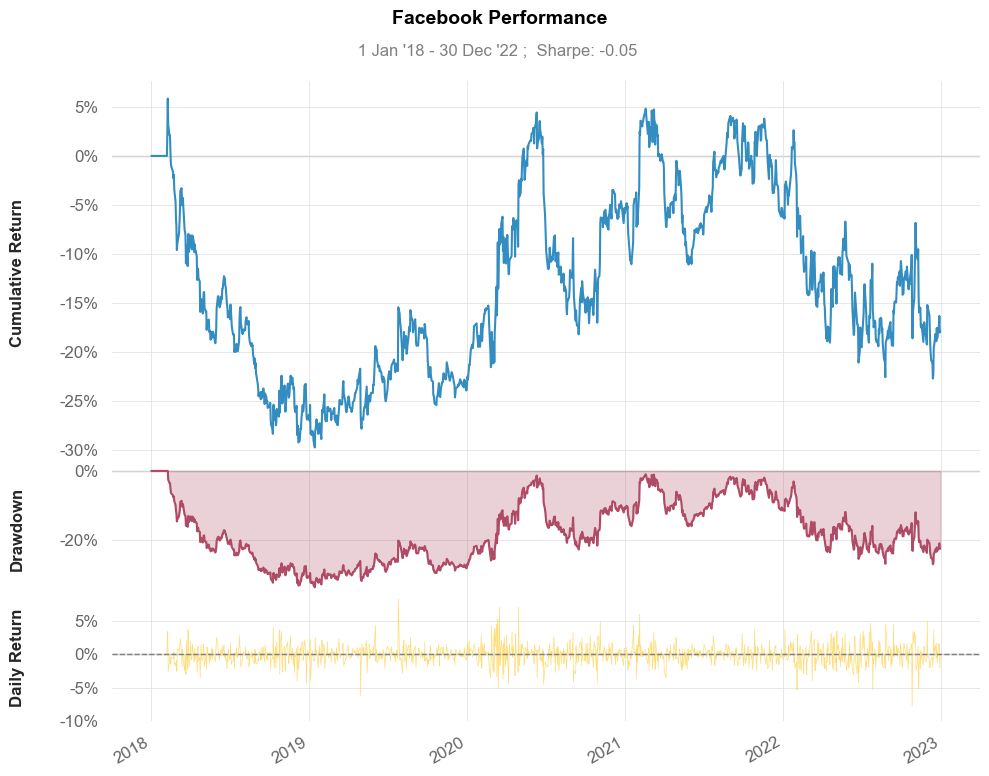

In [ ]:
%matplotlib inline
qs.plots.snapshot(result["_equity"], title='Facebook Performance', show=True)